# Sentinal2 mangroves

**what does this notebook do?** this notebook builds on the **GettingStartedWithSentinel2** notebook; it ueses a loop to load data from sentinal 2 A and B over a set period of time, for a set area and concatinates them together. The data is then cast to float format and used to calculate the geomedian for the selected time range. visible light bands are then plotted at a tre colour image. 

**Tags**
`Sentinel2`, `products`, `GeoMedian`, `threeBandImage`, `dc.load`, `query`, `beginner`, `plot`, `image`,

**Please Note when you start your VDI session you need to module add the `agdc_statistics` module after `dea-prod` to be able to import `datacube_stats`**

In [1]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats import statistics

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import datacube_stats

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


Failed to resolve driver datacube.plugins.index::s3aio_index


In [7]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('title string', fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')
        
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [16]:
#set up peramiters for data loading

sensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-17.523, -17.746),
        'lon': (139.584, 139.95),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2015-08-01', '2017-08-20')
        }
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)

data_sent = {}

for i in sensors:
    this_sensor = s2aws.load(product= i, measurements=bands_of_int, group_by='solar_day', **query)
    
    #retreive projection infromation
    crs = this_sensor.crs
    crswkt = this_sensor.crs.wkt
    affine = this_sensor.affine
    
    #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
    #clear_pixels = this_sensor.pixel_quality == 1
    #clear_data = this_sensor.where(clear_pixels)
    
    data_sent[i] = this_sensor

In [17]:
#look at the data 
data_sent

<xarray.Dataset>
Dimensions:  (time: 33, x: 4032, y: 2698)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-12T01:01:32.459000 ...
  * y        (y) float64 -1.893e+06 -1.893e+06 -1.893e+06 -1.893e+06 ...
  * x        (x) float64 8.044e+05 8.044e+05 8.044e+05 8.044e+05 8.044e+05 ...
Data variables:
    red      (time, y, x) int16 3069 3168 3041 2851 2170 2071 2157 2633 3106 ...
    blue     (time, y, x) int16 1844 1928 1860 1692 1324 1177 1143 1407 1718 ...
    green    (time, y, x) int16 2504 2554 2418 2253 1681 1626 1706 2088 2475 ...
Attributes:
    crs:      EPSG:3577

<IPython.core.display.Javascript object>


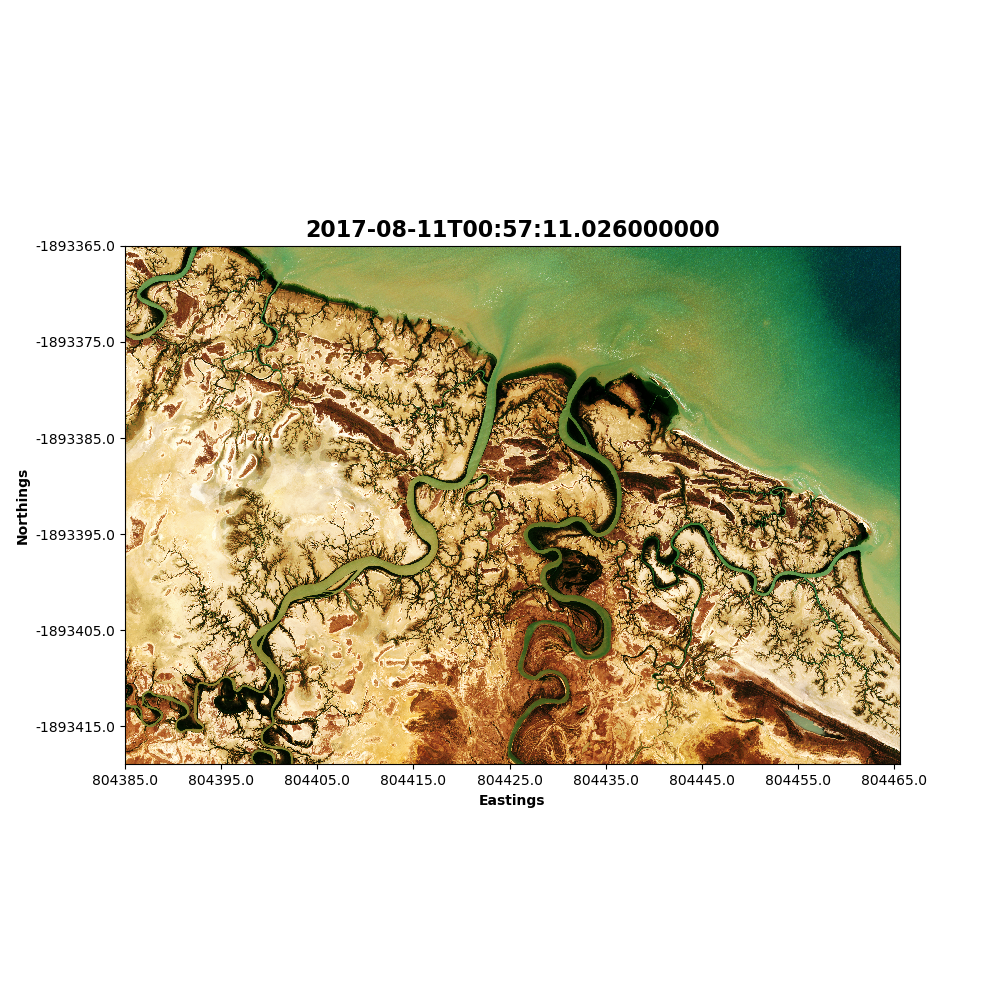

In [20]:
threeBandImage(data_sent, time = 32, bands = ['red', 'green', 'blue'])

#concatinate all of the sentinal data together into one xarray, ordered by time 

data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine


In [10]:
data_sent

<xarray.Dataset>
Dimensions:  (time: 47, x: 1049, y: 1224)
Coordinates:
  * y        (y) float64 -3.954e+06 -3.954e+06 -3.954e+06 -3.954e+06 ...
  * x        (x) float64 1.547e+06 1.547e+06 1.547e+06 1.547e+06 1.547e+06 ...
  * time     (time) datetime64[ns] 2017-01-05T00:02:12.026000 ...
Data variables:
    red      (time, y, x) int16 887 744 683 687 683 653 636 665 661 648 620 ...
    blue     (time, y, x) int16 671 628 605 623 625 603 575 593 584 585 544 ...
    green    (time, y, x) int16 804 734 706 711 697 685 640 674 640 637 620 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 10.00, 0.00, 1546830.00|\n| 0.00,-10.00,-3953690.00|\n| 0.00,...

#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#have a look at the data, you can see it's now in float format
data_sent_flt 

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)

#have a look at the geomedian data
Sentinal_gm

In [15]:
#Prepare geomedian imagery for plotting

rgb = Sentinal_gm.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


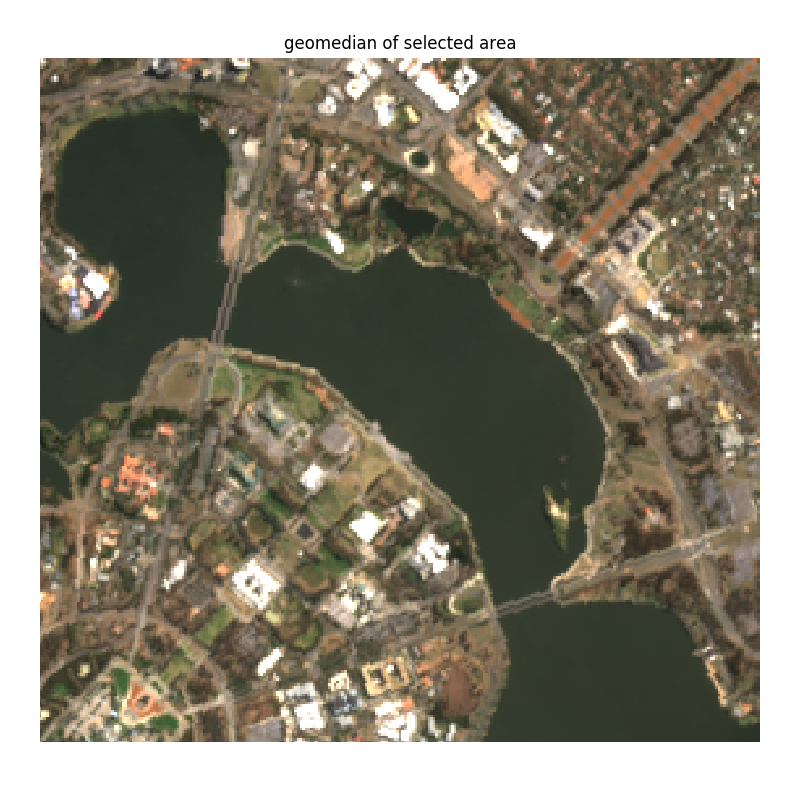

In [19]:
fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [17]:
#end notebook

<IPython.core.display.Javascript object>


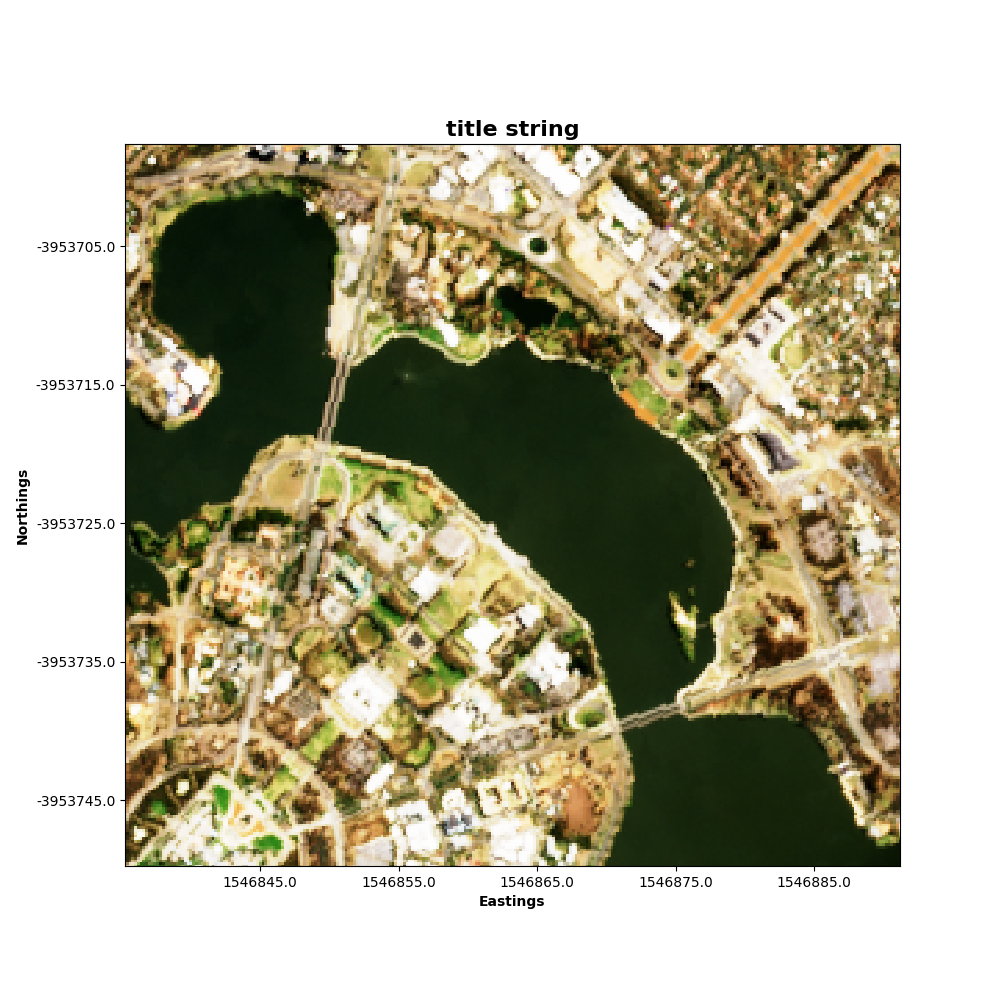

In [21]:
three_band_image(Sentinal_gm, bands = ['red', 'green', 'blue'])